这个笔记本使用原生 Python 绑定，为 MuJoCo 物理提供了一个入门教程
摘自：https://github.com/google-deepmind/mujoco/blob/main/python/tutorial.ipynb

# All imports

In [1]:
# !pip install mujoco

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
    print('Checking that the installation succeeded:')
    import mujoco
    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


# Example: Simulating free bodies with the self-inverting "tippe-top"  示例：使用自倒置的"尖顶倒立摆"模拟自由体

""

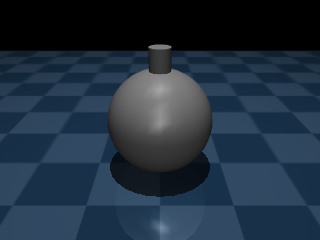

In [5]:
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
"""
<mujoco model="tippe top">
  <option integrator="RK4"/>  # integrator:数值积分器

  <asset>  # 定义资源的分组元素
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>  # texture:这个元素创建一个纹理资源
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>  # camera:相机 xyaxes:相机坐标系的方向
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>  # keyframe:关节帧
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>"""

# 创建模型和数据
model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)  # void mj_forward(const mjModel* m, mjData* d);:正向运动学：与mj_step相同，但不进行时间积分
with mujoco.Renderer(model) as renderer:
    renderer.update_scene(data, camera="closeup")

    media.show_image(renderer.render())

In [3]:
print('positions', data.qpos)  # position 位置和四元数
print('velocities', data.qvel)  # velocities  

positions [0.   0.   0.02 1.   0.   0.   0.  ]
velocities [0. 0. 0. 0. 0. 0.]


In [13]:
# 设置模拟持续时间（秒）和帧率
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.  # 模拟并显示视频
frames = []  # 用于保存每一帧的图像
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0  # 将状态重置到关键帧0
#void mj_resetDataKeyframe(const mjModel* m, mjData* d, int key);重置数据。如果 0 <= key < nkey，则从指定的关键帧设置字段
# 使用Renderer进行渲染
with mujoco.Renderer(model) as renderer:
    # 持续仿真，直到时间达到duration秒
    while data.time < duration:
        # 推进仿真一步
        mujoco.mj_step(model, data)
        # 如果帧数没达到目标，则采样并保存当前帧
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, "closeup")  # 渲染场景
            #update_scene:更新用于渲染的几何体
            pixels = renderer.render()  # 渲染当前帧的像素
            frames.append(pixels)  # 保存到帧列表

# 在Jupyter Notebook中显示视频
media.show_video(frames, fps=framerate)

### Measuring values from `mjData` 测量mjData的值

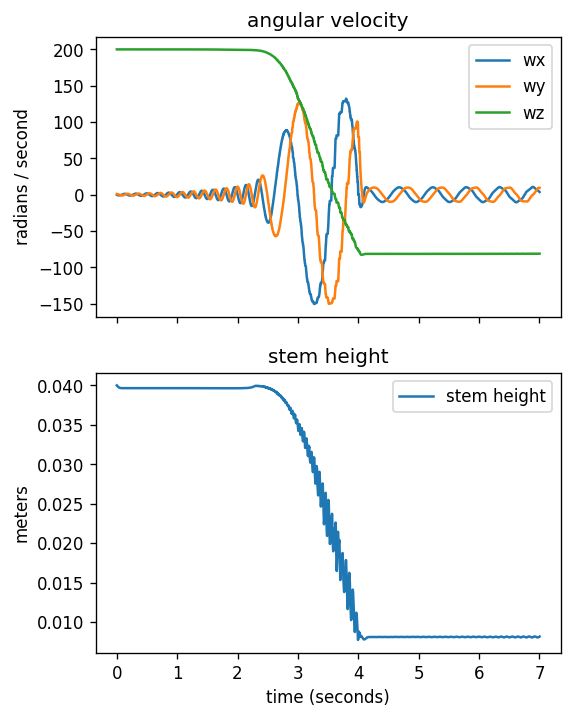

In [17]:
# 用于保存时间、角速度和茎的高度
timevals = []  # 时间戳
angular_velocity = []  # 角速度
stem_height = []  # 几何体的z坐标（高度）

## Simulate and save data  # 模拟并保存数据
# 重置模拟到关键帧 0（初始状态）
mujoco.mj_resetDataKeyframe(model, data, 0)
# 运行仿真并采集数据
while data.time < duration:
    mujoco.mj_step(model, data)  # 推进一步仿真
    timevals.append(data.time)  # 记录时间
    angular_velocity.append(data.qvel[3:6].copy())  # 记录角速度 姿态角速度
    stem_height.append(data.geom_xpos[2,2]);  # 记录第3个几何体的z坐标 geom_xpos:Cartesian geom position (ngeom x 3)

# 设置图像的分辨率和尺寸
dpi = 120
width = 600
height = 800
figsize = (width / dpi, height / dpi)

# 创建一个包含两个子图的Figure，并共享x轴
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

# 第一个字图：绘制角速度
ax[0].plot(timevals, angular_velocity, label=['wx','wy','wz'])
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')
ax[0].legend()

# 第二个子图：绘制茎的高度
ax[1].plot(timevals, stem_height, label='stem height')
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')
ax[1].legend()